In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import datetime
from binance.client import Client


In [3]:
api_key = 'input your API key here.'
api_secret = 'input your API secret here.'
client = Client(api_key,api_secret)

In [4]:
klines = client.get_historical_klines('BTCUSDT', client.KLINE_INTERVAL_5MINUTE, "1 day ago UTC")

df = pd.DataFrame(klines)
df = df.iloc[:,:5]
df[0] = pd.to_datetime(df[0], unit = 'ms')
df.columns = ['date','open','high','low','close']
df.iloc[:,1:5] = df.iloc[:,1:5].astype(float)
df

,date,open,high,low,close
0,2022-08-17 02:15:00,23929.61,23943.07,23900.40,23906.01
1,2022-08-17 02:20:00,23905.03,23924.00,23901.47,23904.44
2,2022-08-17 02:25:00,23903.72,23944.28,23903.14,23935.02
3,2022-08-17 02:30:00,23936.30,23996.88,23927.84,23993.96
4,2022-08-17 02:35:00,23993.96,24058.00,23992.87,24041.08
...,...,...,...,...,...
283,2022-08-18 01:50:00,23453.07,23454.59,23412.83,23419.76
284,2022-08-18 01:55:00,23419.76,23499.19,23415.00,23470.73
285,2022-08-18 02:00:00,23469.40,23475.00,23441.86,23465.65
286,2022-08-18 02:05:00,23465.65,23504.72,23460.28,23489.62


In [5]:
def backtest_dataframe(df):
    position = 0
    net_profit = 0
    percentage_change = []
    df['buy_date'] = ''
    df['sell_date'] = ''

    for i in df.index:
        close = df["close"][i]
        date = df['date'][i]

        # Buy action
        if df["signal"][i] == 1:
            if(position == 0):
                buy_price = close
                position = 1
                df.at[i, 'buy_date'] = date
                print(f"Buying at {str(buy_price)} on {str(date)}")

        # Sell action
        elif (df["signal"][i] == -1):
            if(position == 1):
                sell_price = close
                bought = 0
                position = 0
                df.at[i, 'sell_date'] = date
                print(f"Selling at {str(sell_price)} on {str(date)}")

                # Get percentage change of trade
                pc = (sell_price/buy_price-1)*100
                percentage_change.append(pc)
                net_profit += (sell_price - buy_price)

    # Calculate trade statistics
    gains = 0
    ng = 0
    losses = 0
    nl = 0
    totalR = 1

    for i in percentage_change:
        if(i > 0):
            gains += i
            ng += 1
        else:
            losses += i
            nl += 1
        totalR = totalR * ((i/100)+1)

    totalR = round((totalR-1)*100, 2)

    if(ng > 0):
        avgGain = round(gains/ng, 2)
        maxR = round(max(percentage_change), 2)
    else:
        avgGain = 0
        maxR = "undefined"

    if(nl > 0):
        avgLoss = round(losses/nl, 2)
        maxL = round(min(percentage_change), 2)
    else:
        avgLoss = 0
        maxL = "undefined"

    if(ng > 0 or nl > 0):
        win_rate = round((ng/(ng+nl))*100, 2)
    else:
        win_rate = 0

    print()
    print('Evaluation Metrics:')
    print('-----------------------------------')
    print(f"Number of Trades: {ng+nl}")
    print(f"Number of Gains: {ng}")
    print(f"Number of Losses: {nl}")
    print(f"Total Returns: {totalR}%")
    print(f"Win Rate: {win_rate}%")
    print(f"Average Gain: {avgGain}%")
    print(f"Average Loss: {avgLoss}%")
    print(f"Max Return: {maxR}%")
    print(f"Max Loss: {maxL}%")
    print()

In [6]:
df['ma_200'] = df['close'].rolling(200).mean()

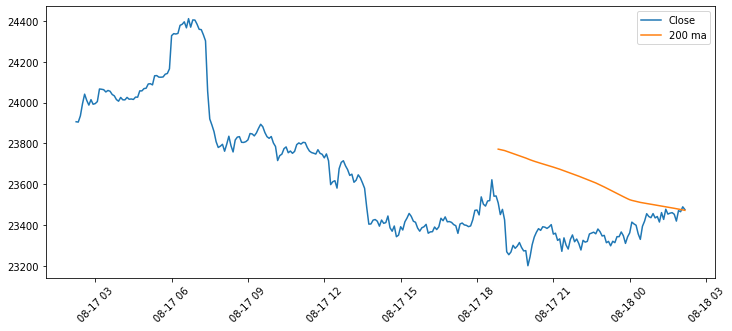

In [7]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

plt.plot(df['date'], df['close'], label = 'Close')
plt.plot(df['date'], df['ma_200'], label = '200 ma')

plt.legend()
plt.show()

In [8]:
period = 20

#Calculate 20-ma and std dev
df['ma_20'] = df['close'].rolling(period).mean()
df['std'] = df['close'].rolling(period).std()

#Calculate bollinger bands using std dev
df['upper_bollinger'] = df['ma_20'] + (2 * df['std'])
df['lower_bollinger'] = df['ma_20'] - (2 * df['std'])

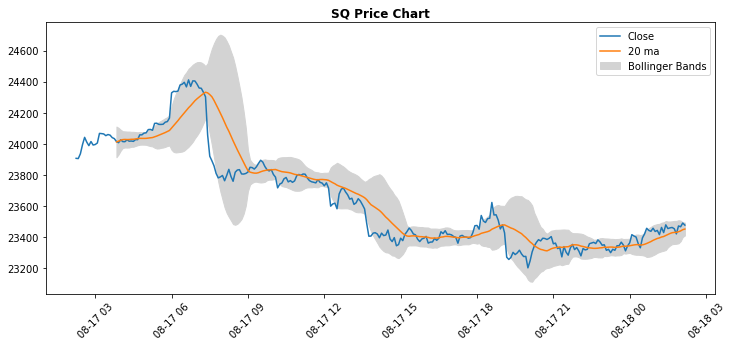

In [9]:
#plot for validation
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

x_axis = df['date']

plt.plot(x_axis, df['close'], label = 'Close')
plt.plot(df['date'], df['ma_20'], label = '20 ma')
plt.fill_between(x_axis, df['upper_bollinger'], df['lower_bollinger'], label = 'Bollinger Bands', color='lightgrey')

plt.title('SQ Price Chart', fontweight="bold")
plt.legend()
plt.show()

In [10]:
def gain(value):
    if value < 0:
        return 0
    else:
        return value

In [11]:
def loss(value):
    if value > 0:
        return 0
    else:
        return abs(value)

In [12]:
period = 6

#Calculate price delta
df['delta'] = df['close'].diff()

#Classify delta into gain & loss
df['gain'] = df['delta'].apply(lambda x:gain(x))
df['loss'] = df['delta'].apply(lambda x:loss(x))

#Calculate ema 
df['ema_gain'] = df['gain'].ewm(period).mean()
df['ema_loss'] = df['loss'].ewm(period).mean()

#Calculate RSI
df['rs'] = df['ema_gain']/df['ema_loss']
df['rsi'] = df['rs'].apply(lambda x: 100 - (100/(x+1)))



(0.0, 100.0)

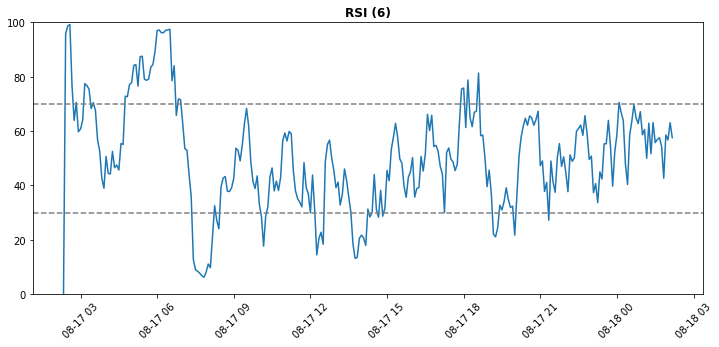

In [13]:
#plot for validation
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

x_axis = df['date']

plt.plot(x_axis, df['rsi'])
plt.axhline(30, c= (.5,.5,.5), ls='--')
plt.axhline(70, c= (.5,.5,.5), ls='--')

plt.title('RSI (6)', fontweight="bold")
plt.ylim([0, 100])

In [16]:
#buy signal
df['signal'] = np.where(
    (df['rsi'] < 30) &
    (df['close'] < df['lower_bollinger']), 1, np.nan)

#sell signal
df['signal'] = np.where(
    (df['rsi'] > 70) & 
    (df['close'] > df['upper_bollinger']), -1, df['signal'])

#buy/sell next trading day
df['signal'] = df['signal'].shift()
df['signal'] = df['signal'].fillna(0)

In [17]:
backtest_dataframe(df)

Buying at 23919.77 on 2022-08-17 07:30:00
Selling at 23473.95 on 2022-08-17 18:00:00
Buying at 23255.19 on 2022-08-17 19:15:00
Selling at 23405.99 on 2022-08-18 00:10:00

Evaluation Metrics:
-----------------------------------
Number of Trades: 2
Number of Gains: 1
Number of Losses: 1
Total Returns: -1.23%
Win Rate: 50.0%
Average Gain: 0.65%
Average Loss: -1.86%
Max Return: 0.65%
Max Loss: -1.86%



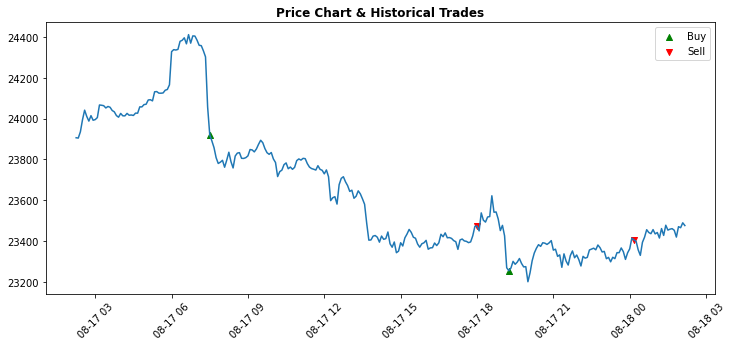

In [18]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

plt.plot(df['date'], df['close'])
plt.scatter(df[(df['signal'] == 1)]['buy_date'], df[(df['signal'] == 1)]['close'], label = 'Buy', marker='^', c='g')
plt.scatter(df[(df['signal'] == -1)]['sell_date'], df[(df['signal'] == -1)]['close'], label = 'Sell', marker='v', c='r')

plt.title('Price Chart & Historical Trades', fontweight="bold")
plt.legend()
plt.show()  